In [1]:
from collections import defaultdict
from queue import Queue, PriorityQueue
import math
from matplotlib import pyplot as plt


class Point(object):
    def __init__(self, x, y, polygon_id=-1):
        self.x = x
        self.y = y
        self.polygon_id = polygon_id
        self.g = 0
        self.pre = None
    
    def rel(self, other, line):
        return line.d(self) * line.d(other) > 0
    
    def can_see(self, other, line):
        l1 = self.line_to(line.p1)
        l2 = self.line_to(line.p2)
        d3 = line.d(self) * line.d(other) < 0
        d1 = other.rel(line.p2,l1)
        d2 = other.rel(line.p1,l2)
        return not (d1 and d2 and d3)
    
    def line_to(self, other):
        return Edge(self, other)
    
    def heuristic(self, other):
        return euclid_distance(self, other)
    
    def __eq__(self, point):
        return point and self.x == point.x and self.y == point.y
    
    def __ne__(self, point):
        return not self.__eq__(point)
    
    def __lt__(self, point):
        return hash(self) < hash(point)
    
    def __str__(self):
        return "(%d,%d)" % (self.x, self.y)
    
    def __hash__(self):
        return self.x.__hash__() ^ self.y.__hash__()
    
    def __repr__(self):
        return "(%d, %d)" % (self.x, self.y)
    

class Edge(object):
    def __init__(self, point1, point2):
        self.p1 = point1
        self.p2 = point2
        
    def get_adjacent(self, point):
        if point == self.p1:
            return self.p2
        if point == self.p2:
            return self.p1
        
    def d(self, point):
        vect_a = Point(self.p2.x - self.p1.x, self.p2.y-self.p1.y)
        vect_n = Point(-vect_a.y, vect_a.x)
        return vect_n.x * (point.x - self.p1.x) + vect_n.y * (point.y - self.p1.y)
    
    def __str__(self):
        return "({},{})".format(self.p1, self.p2)
    
    def __contains__(self, point):
        return self.p1 == point or self.p2 == point
    
    def __hash__(self):
        return self.p1.__hash__() ^ self.p2.__hash__()
    
    def __repr__(self):
        return "Edge({!r}, {!r})".format(self.p1, self.p2)
    

class Graph:
    def __init__(self, polygons):
        self.graph = defaultdict(set)
        self.edges = set()
        self.polygons = defaultdict(set)
        pid = 0
        for polygon in polygons:
            if len(polygon) == 2:
                polygon.pop()
            if polygon[0] == polygon[-1]:
                self.add_point(polygon[0])
            else:
                for i, point in enumerate(polygon):
                    neighbor_point = polygon[(i+1) % len(polygon)]
                    edge = Edge(point, neighbor_point)
                    if len(polygon) > 2:
                        point.polygon_id = pid
                        neighbor_point.polygon_id = pid
                        self.polygons[pid].add(edge)
                    self.add_edge(edge)
                if len(polygon) > 2:
                    pid += 1
                    
    def get_adjacent_points(self, point):
        return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))
    
    def can_see(self, start):
        see_list = list()
        cant_see_list = list()
        
        for polygon in self.polygons:
            for edge in self.polygons[polygon]:
                for point in self.get_points():
                    if start == point:
                        cant_see_list.append(point)
                    if start in self.get_polygon_points(polygon):
                        for poly_point in self.get_polygon_points(polygon):
                            if poly_point not in self.get_adjacent_points(start):
                                cant_see_list.append(poly_point)
                    
                    if point not in cant_see_list:
                        if start.can_see(point, edge):
                            if point not in see_list:
                                see_list.append(point)

                        elif point in see_list:
                            see_list.remove(point)
                            cant_see_list.append(point)
                        else: 
                            cant_see_list.append(point)

        for polygon in self.polygons:
            for edge in self.polygons[polygon]:
                for point in self.get_points():
                    if start == point:
                        cant_see_list.append(point)
                    if start in self.get_polygon_points(polygon):
                        for poly_point in self.get_polygon_points(polygon):
                            if poly_point not in self.get_adjacent_points(start):
                                cant_see_list.append(poly_point)
                    
                    if point not in cant_see_list:
                        if start.can_see(point, edge):
                            if point not in see_list:
                                see_list.append(point)

                        elif point in see_list:
                            see_list.remove(point)
                            cant_see_list.append(point)
                        else: 
                            cant_see_list.append(point)
                    if point in see_list and point in cant_see_list:
                        see_list.remove(point)
        return see_list
    
    def get_polygon_points(self, index):
        point_set = set()
        for edge in self.polygons[index]:
            point_set.add(edge.p1)
            point_set.add(edge.p2)
        return point_set
    
    def get_points(self):
        return list(self.graph)
    
    def get_edges(self):
        return self.edges
    
    def add_point(self, point):
        self.graph[point].add(point)
        
    def add_edge(self, edge):
        self.graph[edge.p1].add(edge)
        self.graph[edge.p2].add(edge)
        self.edges.add(edge)
        
    def __contains__(self, item):
        if isinstance(item, Point):
            return item in self.graph
        if isinstance(item, Edge):
            return item in self.edges
        return False
    
    def __getitem__(self, point):
        if point in self.graph:
            return self.graph[point]
        return set()
    
    def __str__(self):
        res = ""
        for point in self.graph:
            res += "\n" + str(point) + ": "
            for edge in self.graph[point]:
                res += str(edge)
        return res
    
    def __repr__(self):
        return self.__str__()
    
    def h(self, point):
        heuristic = getattr(self, 'heuristic', None)
        if heuristic:
            return heuristic[point]            
        else:
            return -1
        
            
def euclid_distance(point1, point2):
    return round(float(math.sqrt((point2.x - point1.x)**2 + (point2.y - point1.y)**2)), 3)

def search(graph, start, goal, func):
    closed = set()
    queue = PriorityQueue()
    queue.put((0 + func(graph, start), start))
    if start not in closed:
        closed.add(start)
    k=0
    while not queue.empty():
        cost, node = queue.get()
        if node == goal:
            return node
        for i in graph.can_see(node):
            new_cost = node.g + euclid_distance(node, i)
            if i not in closed or new_cost < i.g:
                closed.add(i)
                i.g = new_cost
                i.pre = node
                new_cost = func(graph, i)
                queue.put((new_cost, i))
        k+=1
    return node

a_star = lambda graph, i: i.g + graph.h(i)
greedy = lambda graph, i: graph.h(i)
ucs = lambda graph, i: i.g


In [2]:
def BFS(graph, start, end):
    closed = set()
    queue = Queue()

    queue.put(start)
    if start not in closed:
        closed.add(start)

    while not queue.empty():
        current_node = queue.get()
        closed.add(current_node)

        if current_node == end:
            return current_node

        for node in graph.can_see(current_node):
            if node not in closed:
                closed.add(node)
                node.pre = current_node
                queue.put(node)
    return current_node            


In [3]:
def DFS(graph, start, end):
    closed = set()
    stack = []

    stack.append(start)
    if start not in closed:
        closed.add(start)
        
    while stack != []:
        current_node = stack.pop()
        closed.add(current_node)

        if current_node == end:
            return current_node

        for node in graph.can_see(current_node):
            if node not in closed:
                closed.add(node)
                node.pre = current_node
                stack.append(node)
    return current_node 

Với thuật toán UCS

In [8]:
def main():
    n_polygon = 0
    poly_list = list(list())
    x = list()
    y = list()
    with open('Input.txt', 'r') as f:
        line = f.readline()
        line = line.strip()
        line = line.split()
        line = list(map(int, line))
        n_polygon = line[0]
        start = Point(line[1], line[2])
        goal = Point(line[3], line[4])
        
        poly_list.append([start])
        for line in f:
            point_list = list()
            line = line.split()
            n_vertex = int(line[0])
            for j in range(0, 2*n_vertex, 2):
                point_list.append(Point(int(line[j + 1]), int(line[j + 2])))
            poly_list.append(point_list[:])
        poly_list.append([goal])
        graph = Graph(poly_list)
        graph.heuristic = {point: point.heuristic(goal) for point in graph.get_points()}
        
        a = search(graph, start, goal, ucs)
        
        result = list()
        while a:
            result.append(a)
            a = a.pre
        result.reverse()
        print_res = [[point, point.polygon_id] for point in result]
        print(*print_res, sep=' -> ')
        plt.figure()
        plt.plot([start.x], [start.y], 'ro')
        plt.plot([goal.x], [goal.y], 'ro')
        
        for point in graph.get_points():
            x.append(point.x)
            y.append(point.y)
        plt.plot(x,y,'ro')
        for i in range(1, len(poly_list) - 1):
            coord = list()
            for point in poly_list[i]:
                coord.append([point.x, point.y])
            coord.append(coord[0])
            xs, ys = zip(*coord)
            plt.plot(xs, ys)
        x = list()
        y = list()
        for point in result:
            x.append(point.x)
            y.append(point.y)
        plt.plot(x, y, 'b', linewidth = 2.0)
        plt.show() 
        

C:\Users\Admin\AppData\Local\Temp\ipykernel_18188\2179150615.py:104: DeprecationWarning: NotImplemented should not be used in a boolean context
  return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))


[(2, 4), -1] -> [(4, 7), 0] -> [(16, 9), 2] -> [(24, 19), 3] -> [(25, 21), 5] -> [(38, 21), -1]


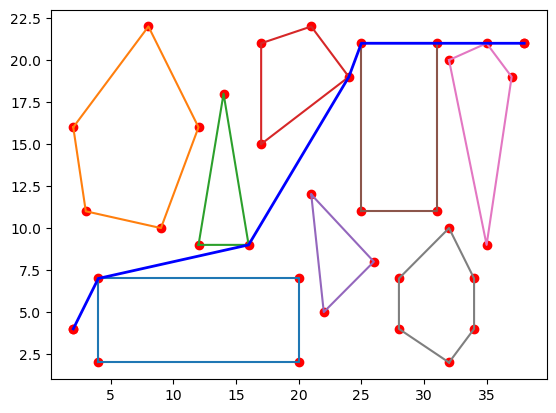

In [9]:
if __name__ == "__main__":
    main()

Với BFS

In [8]:
def main1():
    n_polygon = 0
    poly_list = list(list())
    x = list()
    y = list()
    with open('Input.txt', 'r') as f:
        line = f.readline()
        line = line.strip()
        line = line.split()
        line = list(map(int, line))
        n_polygon = line[0]
        start = Point(line[1], line[2])
        goal = Point(line[3], line[4])
        
        poly_list.append([start])
        for line in f:
            point_list = list()
            line = line.split()
            n_vertex = int(line[0])
            for j in range(0, 2*n_vertex, 2):
                point_list.append(Point(int(line[j + 1]), int(line[j + 2])))
            poly_list.append(point_list[:])
        poly_list.append([goal])
        graph = Graph(poly_list)
        graph.heuristic = {point: point.heuristic(goal) for point in graph.get_points()}
        
        a = BFS(graph, start, goal)
        
        result = list()
        while a:
            result.append(a)
            a = a.pre
        result.reverse()
        print_res = [[point, point.polygon_id] for point in result]
        print(*print_res, sep=' -> ')
        plt.figure()
        plt.plot([start.x], [start.y], 'ro')
        plt.plot([goal.x], [goal.y], 'ro')
        
        for point in graph.get_points():
            x.append(point.x)
            y.append(point.y)
        plt.plot(x,y,'ro')
        for i in range(1, len(poly_list) - 1):
            coord = list()
            for point in poly_list[i]:
                coord.append([point.x, point.y])
            coord.append(coord[0])
            xs, ys = zip(*coord)
            plt.plot(xs, ys)
        x = list()
        y = list()
        for point in result:
            x.append(point.x)
            y.append(point.y)
        plt.plot(x, y, 'b', linewidth = 2.0)
        plt.show() 
        

C:\Users\Admin\AppData\Local\Temp\ipykernel_20132\2445691368.py:104: DeprecationWarning: NotImplemented should not be used in a boolean context
  return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))


[(2, 4), -1] -> [(4, 2), 0] -> [(32, 2), 7] -> [(34, 4), 7] -> [(38, 21), -1]


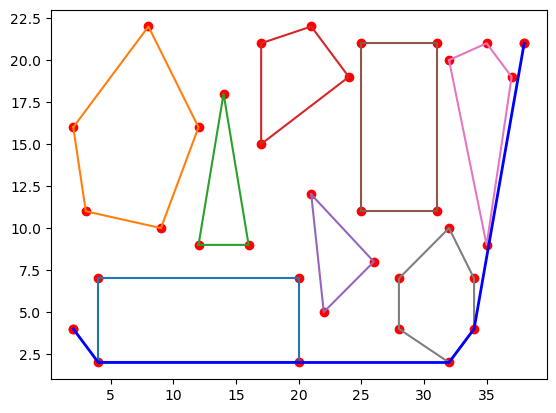

In [9]:
if __name__ == "__main__":
    main1()

Với DFS

In [12]:
def main2():
    n_polygon = 0
    poly_list = list(list())
    x = list()
    y = list()
    with open('Input.txt', 'r') as f:
        line = f.readline()
        line = line.strip()
        line = line.split()
        line = list(map(int, line))
        n_polygon = line[0]
        start = Point(line[1], line[2])
        goal = Point(line[3], line[4])
        
        poly_list.append([start])
        for line in f:
            point_list = list()
            line = line.split()
            n_vertex = int(line[0])
            for j in range(0, 2*n_vertex, 2):
                point_list.append(Point(int(line[j + 1]), int(line[j + 2])))
            poly_list.append(point_list[:])
        poly_list.append([goal])
        graph = Graph(poly_list)
        graph.heuristic = {point: point.heuristic(goal) for point in graph.get_points()}
        
        a = DFS(graph, start, goal)
        
        result = list()
        while a:
            result.append(a)
            a = a.pre
        result.reverse()
        print_res = [[point, point.polygon_id] for point in result]
        print(*print_res, sep=' -> ')
        plt.figure()
        plt.plot([start.x], [start.y], 'ro')
        plt.plot([goal.x], [goal.y], 'ro')
        
        for point in graph.get_points():
            x.append(point.x)
            y.append(point.y)
        plt.plot(x,y,'ro')
        for i in range(1, len(poly_list) - 1):
            coord = list()
            for point in poly_list[i]:
                coord.append([point.x, point.y])
            coord.append(coord[0])
            xs, ys = zip(*coord)
            plt.plot(xs, ys)
        x = list()
        y = list()
        for point in result:
            x.append(point.x)
            y.append(point.y)
        plt.plot(x, y, 'b', linewidth = 2.0)
        plt.show() 

C:\Users\admin\AppData\Local\Temp\ipykernel_9448\1418428893.py:104: DeprecationWarning: NotImplemented should not be used in a boolean context
  return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))


[(2, 4), -1] -> [(3, 11), 1] -> [(12, 9), 2] -> [(14, 18), 2] -> [(22, 5), 4] -> [(32, 10), 7] -> [(34, 7), 7] -> [(34, 4), 7] -> [(38, 21), -1]


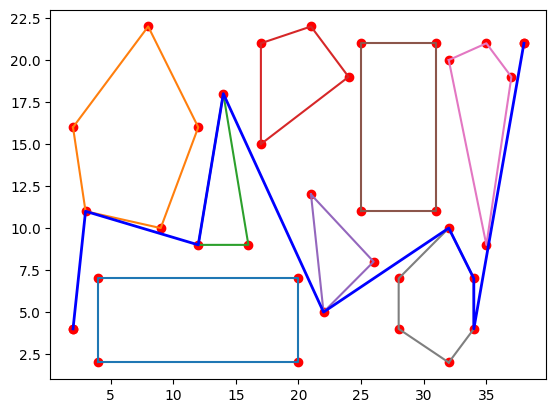

In [68]:
if __name__ == "__main__":
    main2()